# Data Preprocessing
---

In [104]:
#Import the library to be used
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import numpy as np
from PIL import Image
import os

In [105]:
print(f"Using TensorFlow version: {tf.__version__}")
print(f"Using TensorFlow Hub version: {hub.__version__}")
print(f"Using Numpy version: {np.__version__}")
print(f"GPU Device Found." if tf.config.list_physical_devices('GPU') else "GPU Device Not Found. Running on CPU")

Using TensorFlow version: 2.12.0
Using TensorFlow Hub version: 0.13.0
Using Numpy version: 1.23.5
GPU Device Not Found. Running on CPU


In [106]:
num_classes = 8

In [107]:
# Determine the training and validation dataset paths
dataset_path = 'Fitur1_split'
train_data_dir = os.path.join(dataset_path, 'training')
validation_data_dir = os.path.join(dataset_path, 'validation')

Label shown is: SEPATU
training Images:


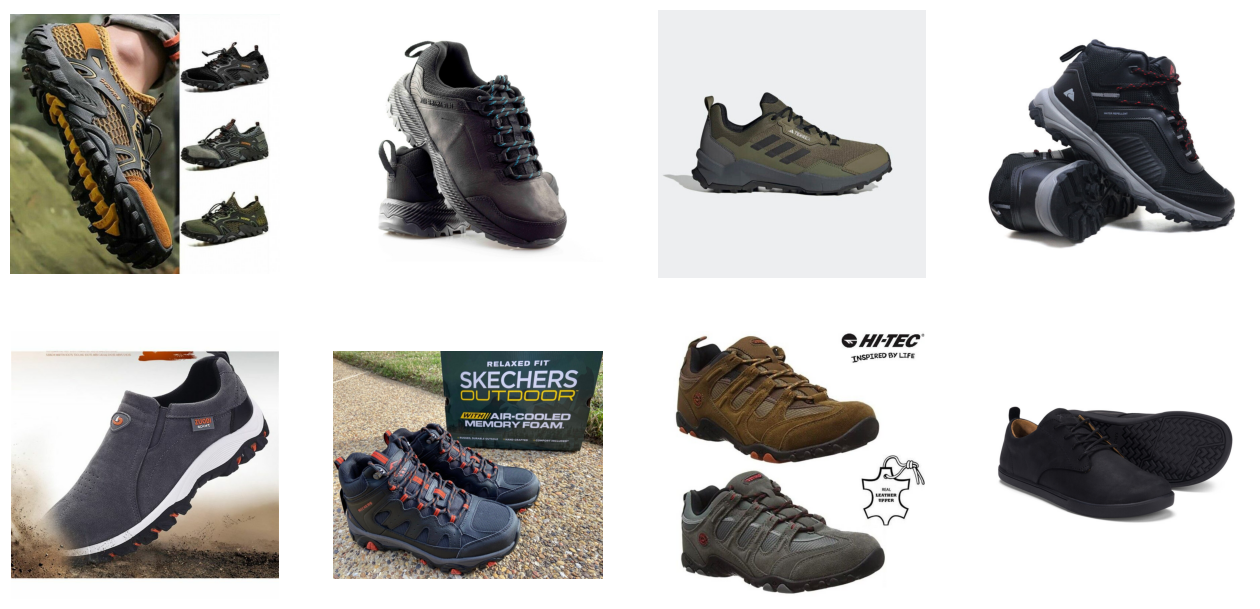

In [108]:
def view_data(rows, cols, pic_index, label, dataset_type):
    print(f"Label shown is: {label}")
    fig = plt.gcf()
    fig.set_size_inches(rows*4, cols*4)
    
    pic_index += 8
    used_path = os.path.join(dataset_path, dataset_type)
    
    next_images = [os.path.join(used_path, label, file)
                        for file in os.listdir(os.path.join(used_path, label))[pic_index-8:pic_index]
                        ]
    
    print(f"{dataset_type} Images:")
    for index, img_path in enumerate(next_images):
        sp = plt.subplot(rows, cols, index +1)
        sp.axis("off")
        
        img = mpimg.imread(img_path)
        plt.imshow(img)

folders = os.listdir(train_data_dir)
rows = 4
cols = 4
image_index = 12
view_data(rows, cols, image_index, folders[4], "training") #Look at the data in the 5th folder from the training dataset

In [109]:
# Want to know the training dataset information
tempPath = os.path.join(dataset_path, "training")
datasetClass = os.listdir(tempPath)
datasetImage_count = 0

for label in datasetClass:
    temp = []
    for file in os.listdir(os.path.join(tempPath, label)):
        temp.append(file)
    datasetImage_count += len(temp)

print(f"There are {len(datasetClass)} labels with {datasetImage_count} images")

There are 8 labels with 2400 images


# Recale and assign catagorical lables
---

In [110]:
# Set image augmentation using ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range= 20,  # Image rotation within 20 degrees
    width_shift_range= 0.2, # The horizontal shift of the image is 20% of the image width
    height_shift_range= 0.2, # The vertical shift of the image is 20% of the image height
    zoom_range= 0.2,  # Enlarge and reduce the image by 20%
    horizontal_flip= True, # Flipping the image horizontally
    fill_mode= 'nearest' ,
    shear_range= 0.2,# Fill in the empty pixels with the closest pixels  
    rescale= 1./255
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)

In [111]:
# Load training and test datasets using ImageDataGenerator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size= 32,
    shuffle= True, 
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(150, 150),
    batch_size= 32,  
    shuffle= True,
    class_mode='categorical'
)


Found 2400 images belonging to 8 classes.
Found 1200 images belonging to 8 classes.


# CNN Model Using Transfer Learning VGG16 Model Initialization
---

In [112]:
# Using transfer learning with the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [113]:
# Freeze all layers on the transfer learning model
for layer in base_model.layers:
    layer.trainable = False

In [114]:
# Added a global pooling layer and a classification layer 
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax')) 

In [115]:
# Show the model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_11 (Flatten)        (None, 8192)              0         
                                                                 
 dense_26 (Dense)            (None, 512)               4194816   
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 8)                 4104      
                                                                 
Total params: 18,913,608
Trainable params: 4,198,920
Non-trainable params: 14,714,688
_________________________________________________________________


In [116]:
# Define optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Using callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.89):
      print("\nAkurasi telah mencapai >89%!") 
      self.model.stop_training = True
callbacks = myCallback()

In [76]:
# Train the model using training and validation datasets
early_stopping = EarlyStopping(monitor='val_loss', patience=7)


history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs= 40,
    validation_data= validation_generator,
    validation_steps= validation_generator.n // validation_generator.batch_size,
    callbacks=[callbacks]
)


Epoch 1/40
75/75 [==============================] - 172s 2s/step - loss: 0.9373 - accuracy: 0.7058 - val_loss: 0.5156 - val_accuracy: 0.8201
Epoch 2/40
75/75 [==============================] - 195s 3s/step - loss: 0.4762 - accuracy: 0.8338 - val_loss: 0.4381 - val_accuracy: 0.8615
Epoch 3/40
75/75 [==============================] - 186s 2s/step - loss: 0.4272 - accuracy: 0.8508 - val_loss: 0.4181 - val_accuracy: 0.8598
Epoch 4/40
75/75 [==============================] - 185s 2s/step - loss: 0.3419 - accuracy: 0.8788 - val_loss: 0.4472 - val_accuracy: 0.8547
Epoch 5/40
75/75 [==============================] - 195s 3s/step - loss: 0.3284 - accuracy: 0.8871 - val_loss: 0.5911 - val_accuracy: 0.7990
Epoch 6/40
75/75 [==============================] - 188s 3s/step - loss: 0.2938 - accuracy: 0.8979 - val_loss: 0.4857 - val_accuracy: 0.8421
Epoch 7/40
75/75 [==============================] - 175s 2s/step - loss: 0.2985 - accuracy: 0.8942 - val_loss: 0.4388 - val_accuracy: 0.8564
Epoch 8/40
75

In [117]:
test_loss, test_acc = model.evaluate_generator(validation_generator, steps=len(validation_generator))
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20652\3304394409.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(validation_generator, steps=len(validation_generator))


Test Loss: 2.3161892890930176
Test Accuracy: 0.09666666388511658


In [118]:
def result_visualization(model_result, type):
    train = model_result.history[type]
    val = model_result.history[f"val_{type}"]
    
    epochs = range(len(train))
    if type == "accuracy":
        plt.plot(epochs, train, 'r', label="Training Accuracy")
        plt.plot(epochs, val, 'b', label="Validation Accuracy")
        plt.title("Training and Validation Accuracy")
    elif type == "loss":
        plt.plot(epochs, train, 'r', label="Training Loss")
        plt.plot(epochs, val, 'b', label="Validation Loss")
        plt.title("Training and Validation Loss")
    plt.legend(loc=0)
    plt.figure()
    plt.show()

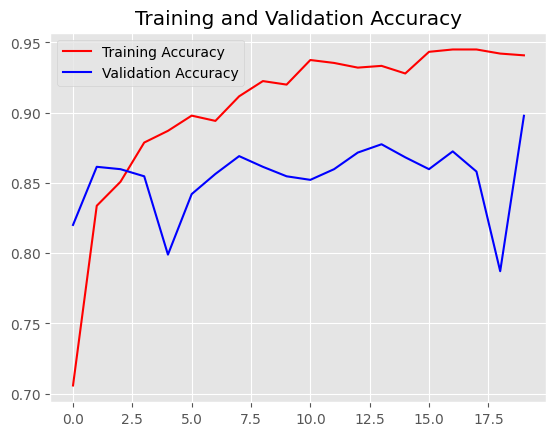

<Figure size 640x480 with 0 Axes>

In [119]:
result_visualization(history, "accuracy") # >89%, Epoch = 40, Batch Size = 32

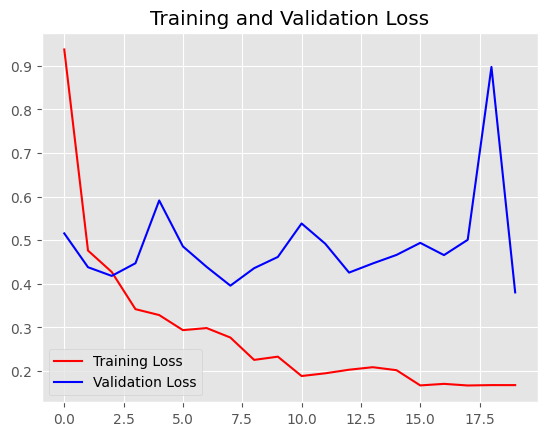

<Figure size 640x480 with 0 Axes>

In [120]:
result_visualization(history, "loss") # >89%, Epoch = 40, Batch Size = 32

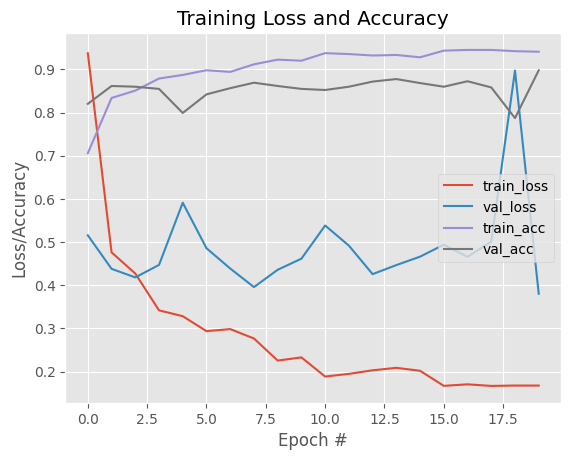

In [121]:
# plot the training loss and accuracy
N = len(history.history['loss'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.show()


CATEGORY CLASSIFICATION 8 types of goods
Enter a category type =  MATRAS
Please upload a picture MATRAS

Enter image path: test_matras.jpg


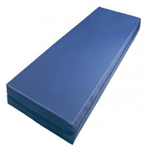

1/1 [==============================] - 0s 426ms/step
RESULTS OF ITS DETECTION: 

Upload successfully MATRAS


In [133]:
##Test Model

print("CATEGORY CLASSIFICATION 8 types of goods")
inputan = input("Enter a category type =  ").upper()
if inputan in ['LCD', 'MATRAS', 'TENDA', 'CAMERA', 'SEPATU', 'SPEAKER','PS','TAS']:
    print("Please upload a picture", inputan)
    print()

    # Accept image input from users
    path = input("Enter image path: ")

    # Resize the image according to the needs of the model
    img = Image.open(path).resize((150,150))

    # View uploaded images
    display(img)

    # Convert images to arrays
    x = np.array(img)
    # Add a new dimension to an array
    x = np.expand_dims(x, axis=0)
    # Combine arrays into a stack
    images = np.vstack([x])

    # Make predictions with models
    classes = model.predict(images, batch_size=10)

    # Check prediction results
    print("RESULTS OF ITS DETECTION: ")
    print()

    if np.argmax(classes) == 0:
        hasil = 'CAMERA'
    elif np.argmax(classes) == 1:
        hasil = 'LCD'
    elif np.argmax(classes) == 2:
        hasil = 'MATRAS'
    elif np.argmax(classes) == 3:
        hasil = 'PS'
    elif np.argmax(classes) == 4:
        hasil = 'SEPATU'
    elif np.argmax(classes) == 5:
        hasil = 'SPEAKER'
    elif np.argmax(classes) == 6:
        hasil = 'TAS'
    elif np.argmax(classes) == 7:
        hasil = 'TENDA'       
    else:
        print('Image FALSE')
        hasil = None

    if hasil is not None:
        if inputan == hasil:
            print("Upload successfully", hasil)
        else:
            print("Failed, the image is", hasil, "not ", inputan)
else:
    print("category", inputan, "not available")

